# **Maestría en Inteligencia Artificial Aplicada**
## Proyecto Integrador (Gpo 26)
> ### Tecnológico de Monterrey
>### **AVANCE 3** = BASELINE


## -

## **Automatización del Registro de Materiales Médicos mediante Visión Computacional**


### EQUIPO 26


* ### Luis Fernando Rojas Marta - A00757351
* ### Jose Eduardo Carreon - A01372413


### *Librerias*

In [1]:
#Librerias
import os
from ultralytics import YOLO    #Libreria YOLO## YOLO - Modelo
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import easyocr                  #Libreria EasyOCR
import pandas as pd             #Para Dataframes y manipulacion de los valores
import re                       #Manipulacion de caracteres

## YOLO - Modelo

In [2]:
#Cargar modelo entrenado
modelo = YOLO('/Users/fer/Downloads/Proyecto Integrador (DEL)/YOLO/yolo11_obb_training3_avance/weights/best.pt')

#Ruta a las imagenes a analizar
carpeta_test = '/Users/fer/Downloads/Proyecto Integrador (DEL)/All photos/Fotos_Etiquetas_4_for_test'

#Realizar  predicciones
results = modelo.predict(source=carpeta_test, save=True, conf=0.25)


image 1/96 /Users/fer/Downloads/Proyecto Integrador (DEL)/All photos/Fotos_Etiquetas_4_for_test/test_label_1.JPG: 640x480 None51.0ms
image 2/96 /Users/fer/Downloads/Proyecto Integrador (DEL)/All photos/Fotos_Etiquetas_4_for_test/test_label_10.JPG: 640x480 None32.7ms
image 3/96 /Users/fer/Downloads/Proyecto Integrador (DEL)/All photos/Fotos_Etiquetas_4_for_test/test_label_11.JPG: 640x480 None34.2ms
image 4/96 /Users/fer/Downloads/Proyecto Integrador (DEL)/All photos/Fotos_Etiquetas_4_for_test/test_label_12.JPG: 640x480 None28.6ms
image 5/96 /Users/fer/Downloads/Proyecto Integrador (DEL)/All photos/Fotos_Etiquetas_4_for_test/test_label_13.JPG: 640x480 None34.0ms
image 6/96 /Users/fer/Downloads/Proyecto Integrador (DEL)/All photos/Fotos_Etiquetas_4_for_test/test_label_14.JPG: 640x480 None43.1ms
image 7/96 /Users/fer/Downloads/Proyecto Integrador (DEL)/All photos/Fotos_Etiquetas_4_for_test/test_label_15.JPG: 640x480 None37.5ms
image 8/96 /Users/fer/Downloads/Proyecto Integrador (DEL)/All 

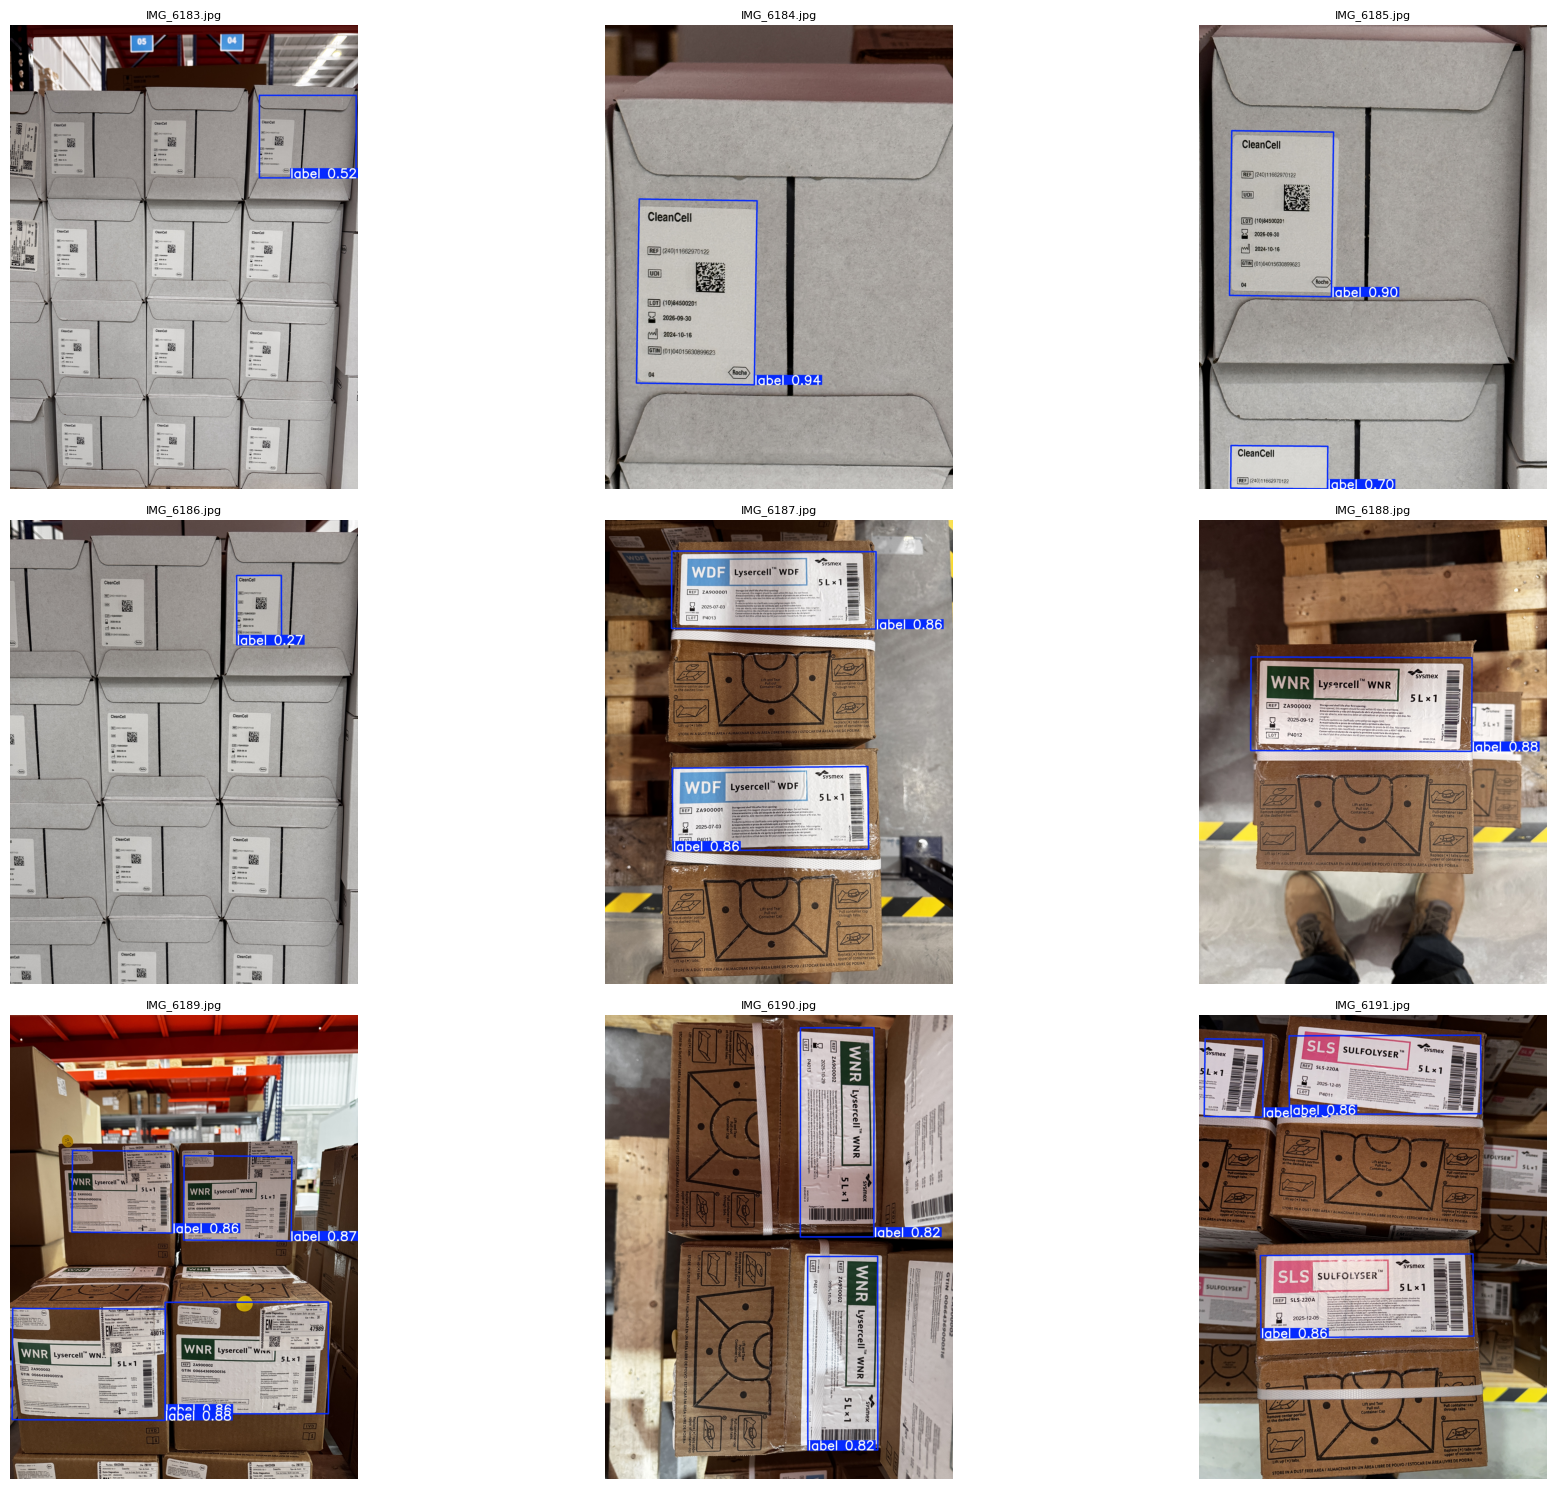

In [3]:

#Ruta donde se guardaron las imagenes con las predicciones: 
carpeta_resultados = 'runs/obb/predict'
imagenes = sorted([f for f in os.listdir(carpeta_resultados) if f.endswith(('.jpg', '.png'))])[:9]  #Solo las 9 primeras

#Parametros para la visualizacion
imagenes_por_fila = 3
total_imagenes = len(imagenes)
filas = (total_imagenes + imagenes_por_fila - 1) // imagenes_por_fila

plt.figure(figsize=(20, 5 * filas))

for i, nombre in enumerate(imagenes):
    ruta = os.path.join(carpeta_resultados, nombre)
    img = mpimg.imread(ruta)
    plt.subplot(filas, imagenes_por_fila, i + 1)
    plt.imshow(img)
    plt.title(nombre, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()
     

## OCR - Analisis y extracción de datos

In [4]:
##### 
# FUNCIONES PARA OBTENCION DE VALORES
#####

###### Funcion para extraer fechas en formato AAAA-MM-DD
def extraer_fechas(results_df):
    #Uso de Regex para el formato de fecha
    fecha_patron = r"\b\d{4}-\d{2}-\d{2}\b"
    fechas = []

    #Verificar si hay al menos dos columnas
    if results_df.shape[1] < 2:
        print("Advertencia: El DataFrame no tiene al menos dos columnas.")
        return "NA", "NA"

    for idx, texto in results_df.iloc[:, 1].items():  # Accede a la columna 1 ("Text")
        if pd.isna(texto):
            continue

        fechas_encontradas = re.findall(fecha_patron, texto)
        fechas.extend(fechas_encontradas)

    #eliminar duplicados y ordenar por fecha
    fechas = sorted(list(set(fechas)))

    #Determinar FAB y CAD
    fab_fecha = fechas[0] if len(fechas) > 0 else "NA"
    cad_fecha = fechas[1] if len(fechas) > 1 else "NA"

    return fab_fecha, cad_fecha

##### Funcion para buscar valores por etiquetas
def extraer_valores_por_tag(results_df, tags):
    valores = {tag: "NA" for tag in tags}

    #Verificar si hay al menos dos columnas
    if results_df.shape[1] < 2:
        print("Advertencia: El DataFrame no tiene al menos dos columnas.")
        return valores

    for tag in tags:
        for idx, texto in results_df.iloc[:, 1].items():  # Accede a la columna 1 ("Text")
            if pd.isna(texto):
                continue

            #Se limpia el texto para comparacion
            clean_texto = texto.upper().replace("[", "").replace("]", "")

            #Caso 1: Si es exactamente igual (etiqueta sola), tomamos siguiente entrada
            if clean_texto.strip() == tag:
                if idx + 1 in results_df.index:
                    valores[tag] = results_df.iloc[idx + 1, 1]
                break

            #Caso 2: Si la etiqueta viene combinada con el valor
            elif tag in clean_texto:
                match = re.search(rf"{tag}\s*[:\-]?\s*([A-Z0-9]+)", clean_texto)
                if match:
                    valores[tag] = match.group(1)
                    break

    return valores

In [5]:
######
# Obtencion de los Dataframes - UNICAMENTE SERA NECESARIO PARA ESTA ENTREGA:
######

#Lector de EasyOCR
lector = easyocr.Reader(['es', 'en'])  # Español e inglés

# Directorio de la carpeta con imagenes
ruta_carpeta = '/Users/fer/Downloads/Proyecto Integrador (DEL)/All photos/Fotos_Etiquetas_1/'

#Imagenes a procesar
nombres_imagenes = ["label_1.jpg", "label_2.jpg", "label_3.jpg", "label_4.jpg", "label_5.jpg"]


    #Se crean cinco dataframes, uno para cada imagen
df1, df2, df3, df4, df5 = None, None, None, None, None

#Ciclo FOR para las 5 primeras imagenes
for i, nombre_imagen in enumerate(nombres_imagenes[:5]):
    ruta_imagen = os.path.join(ruta_carpeta, nombre_imagen)
    print(f"Procesando imagen {i+1}: {ruta_imagen}")

#Verificacion de imagen
    img = cv2.imread(ruta_imagen)
    if img is None:
        print(f"No se pudo cargar la imagen {ruta_imagen}, ")
        continue

    try:
#############
# SECCION 1: Obtencion de Texto usando EasyOCR y creacion del DF
#############
        results = lector.readtext(ruta_imagen)
        #results_df = pd.DataFrame(results, columns=["BBox", "Text", "Confidence"])
        if len(results) > 0:
            results_df = pd.DataFrame(results, columns=["BBox", "Text", "Confidence"])
        else:
            # Si no se detecta texto, crear un DataFrame vacío con las columnas esperadas
            results_df = pd.DataFrame(columns=["BBox", "Text", "Confidence"])

        
        #Asignacion del dataframe 'results_df' al dataframe correspondiente a la imagen
        if i == 0:
            df1 = results_df
        elif i == 1:
            df2 = results_df
        elif i == 2:
            df3 = results_df
        elif i == 3:
            df4 = results_df
        elif i == 4:
            df5 = results_df

        print(f"Imagen {i+1} procesada y guardada en df{i+1}.")
        
    except Exception as e:
        print(f"Error al procesar la imagen {ruta_imagen}: {e}")

print("Proceso finalizado")


Procesando imagen 1: /Users/fer/Downloads/Proyecto Integrador (DEL)/All photos/Fotos_Etiquetas_1/label_1.jpg
Imagen 1 procesada y guardada en df1.
Procesando imagen 2: /Users/fer/Downloads/Proyecto Integrador (DEL)/All photos/Fotos_Etiquetas_1/label_2.jpg
Imagen 2 procesada y guardada en df2.
Procesando imagen 3: /Users/fer/Downloads/Proyecto Integrador (DEL)/All photos/Fotos_Etiquetas_1/label_3.jpg
Imagen 3 procesada y guardada en df3.
Procesando imagen 4: /Users/fer/Downloads/Proyecto Integrador (DEL)/All photos/Fotos_Etiquetas_1/label_4.jpg
Imagen 4 procesada y guardada en df4.
Procesando imagen 5: /Users/fer/Downloads/Proyecto Integrador (DEL)/All photos/Fotos_Etiquetas_1/label_5.jpg
Imagen 5 procesada y guardada en df5.
Proceso finalizado


In [6]:
######
# Impresion de valores de los Dataframes - ESTE CICLO SOLO ES NECESARIO PARA ESTA ENTREGA:
######

for idx, df in enumerate([df1, df2, df3, df4, df5], start=1):
    if df is not None:
        print(f"\n{'=' * 25}")
        print(f"Procesando Dataframe {idx}")
        tags_list = ["REF", "LOT"]
        tags_valores = extraer_valores_por_tag(df, tags_list)
        print(f" Valores encontrados en Dataframe {idx}: {tags_valores}")

        fab_fecha, cad_fecha = extraer_fechas(df)
        print(f" Fecha de Fabricacion (FAB) en Dataframe {idx}: {fab_fecha}")
        print(f" Fecha de Caducidad (CAD) en Dataframe {idx}: {cad_fecha}\n")

print("Proceso de extraccion de informacion finalizado")


Procesando Dataframe 1
 Valores encontrados en Dataframe 1: {'REF': '(240)20738069122', 'LOT': '(10)79186601'}
 Fecha de Fabricacion (FAB) en Dataframe 1: 2024-02-09
 Fecha de Caducidad (CAD) en Dataframe 1: 2026-01-31


Procesando Dataframe 2
 Valores encontrados en Dataframe 2: {'REF': '(240)07254733190', 'LOT': '(10)81259101'}
 Fecha de Fabricacion (FAB) en Dataframe 2: 2024-08-02
 Fecha de Caducidad (CAD) en Dataframe 2: 2027-05-31


Procesando Dataframe 3
 Valores encontrados en Dataframe 3: {'REF': '(240)11379208191', 'LOT': 'NA'}
 Fecha de Fabricacion (FAB) en Dataframe 3: 2024-05-13
 Fecha de Caducidad (CAD) en Dataframe 3: 2025-08-31


Procesando Dataframe 4
 Valores encontrados en Dataframe 4: {'REF': '(240)04522320190', 'LOT': 'NA'}
 Fecha de Fabricacion (FAB) en Dataframe 4: 2024-05-22
 Fecha de Caducidad (CAD) en Dataframe 4: NA


Procesando Dataframe 5
 Valores encontrados en Dataframe 5: {'REF': '(240) 11706799001', 'LOT': '(10) 24074715'}
 Fecha de Fabricacion (FAB) en